In [ ]:
!pip install torch_geometric
import pandas as pd
import re
import spacy
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import seaborn as sns
import torch.nn.functional as F
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
from google.colab import files

nltk.download('stopwords')
nltk.download('wordnet')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Function for text preprocessing and lemmatization
def preprocess_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\!+', '!', text)
    text = re.sub(r'\/+', '', text)
    text = re.sub(r'`', '', text)
    text = re.sub(r'-lrb-', '-', text)
    text = re.sub(r'-rrb-', '-', text)
    text = re.sub(r'\-+', '-', text)
    text = re.sub(r"\b(i['`’]ve|i['`’]m|i['`’]ll)\b", lambda m: m.group(0).replace("'", " "), text)
    text = re.sub(r" - ", " . ", text)

    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    lemmatized_text = re.sub(r"'s\b", "s", lemmatized_text)
    return lemmatized_text

# Function to extract metaphor-related sentences
def extract_metaphor_sentences(df):
    imp_text = []

    for _, row in df.iterrows():
        metaphor_keyword = metaphor_keywords.get(row['metaphorID'], '')
        selected_sentence = ""

        for sentence in row['lemmatized_text'].split('.'):
            if metaphor_keyword in sentence:
                # Break condition: prioritize sentences without specific punctuation
                if not any(punct in sentence for punct in [' - ', ' , ', ' ; ', ' ? ', ' ! ']):
                    selected_sentence = sentence
                    break

                # Secondary prioritization based on punctuation
                for punct in [' , ', ' ; ', ' ? ', ' ! ', ' - ']:
                    if punct in sentence:
                        for sub_sentence in sentence.split(punct):
                            if metaphor_keyword in sub_sentence:
                                selected_sentence = sub_sentence
                                break
                        if selected_sentence:
                            break

        if selected_sentence:
            imp_text.append(selected_sentence)

    return imp_text

def clean_and_process_data(df):

    # Preprocess and lemmatize text
    df['lemmatized_text'] = df['text'].apply(preprocess_and_lemmatize)

    # Extract metaphor-related sentences
    imp_text = extract_metaphor_sentences(df)

    # Create cleaned DataFrame with important metaphor-related sentences
    cleaned_df = pd.DataFrame({'text': imp_text})
    cleaned_df[["metaphorID", "label"]] = df.iloc[:, :2]

    # Map labels to target binary values
    cleaned_df["target"] = cleaned_df["label"].map({True: 1, False: 0})
    cleaned_df = cleaned_df.drop("label", axis=1)

    # Map metaphorID to metaphor keywords
    cleaned_df["metaphor"] = cleaned_df["metaphorID"].map(metaphor_keywords)
    cleaned_df = cleaned_df.drop("metaphorID", axis=1)

    return cleaned_df

metaphor_keywords = {
    0: 'road',
    1: 'candle',
    2: 'light',
    3: 'spice',
    4: 'ride',
    5: 'train',
    6: 'boat'
}

df = pd.read_csv('train-1.csv')
nlp = spacy.load('en_core_web_sm')
df['label_boolean'] = df['label'].astype(int)
cleaned_df = clean_and_process_data(df)

In [ ]:
X, y = cleaned_df.drop("target", axis = 1), cleaned_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train_text, X_test_text = X_train["text"],  X_test["text"]
X_train_meta, X_test_meta = X_train["metaphor"], X_test["metaphor"]

In [ ]:
X_train_meta

,metaphor
0,ride
1,road
2,ride
3,light
4,road
...,...
1491,ride
1492,light
1493,road
1494,road


> We want to emphasize on type of metaphor that is why it would be taken twice once with the text and then with meta.

## Utility Functions

In [ ]:
def create_bert_embeddings(text_series):
    embeddings = []
    for text in text_series:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return torch.tensor(np.array(embeddings), dtype=torch.float)

# Create a heterogeneous graph
def create_hetero_graph(texts, metas):
    G = nx.Graph()
    word_to_doc_edges = []
    unique_words = set()

    for doc_id, (text, meta) in enumerate(zip(texts, metas)):
        words = set(str(text).lower().split() + str(meta).lower().split())
        unique_words.update(words)
        for word in words:
            word_to_doc_edges.append(('word', word, 'doc', doc_id))

    return list(unique_words), word_to_doc_edges


def visualize_document_word_graph(data, num_docs=5, max_words_per_doc=20):
    """
    Visualizes a graph showing documents, words, and their connections.

    Args:
        data: The HeteroData object containing the graph.
        num_docs: Number of documents to visualize.
        max_words_per_doc: Maximum number of words to show per document.
    """
    edge_index = data['word', 'to', 'doc'].edge_index

    G = nx.Graph()

    all_docs = list(set(edge_index[1].tolist()))
    selected_docs = random.sample(all_docs, min(num_docs, len(all_docs)))

    # Add document nodes
    for doc_idx in selected_docs:
        G.add_node(f'doc_{doc_idx}', color='orange', node_type='doc')

    # Add word nodes and edges
    for doc_idx in selected_docs:
        connected_words = edge_index[0, edge_index[1] == doc_idx].tolist()
        selected_words = random.sample(connected_words, min(max_words_per_doc, len(connected_words)))
        for word_idx in selected_words:
            word_node = f'word_{word_idx}'
            if word_node not in G:
                G.add_node(word_node, color='blue', node_type='word')
            G.add_edge(f'doc_{doc_idx}', word_node)

    # Visualization
    plt.figure(figsize=(20, 16))
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Draw nodes
    doc_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'doc']
    word_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'word']

    nx.draw_networkx_nodes(G, pos, nodelist=doc_nodes, node_color='orange', node_size=3000, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=word_nodes, node_color='blue', node_size=2000, alpha=0.6)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Add labels
    doc_labels = {node: node for node in doc_nodes}
    word_labels = {node: node.split('_')[1] for node in word_nodes}  # Display only the word index
    nx.draw_networkx_labels(G, pos, doc_labels, font_size=12, font_weight="bold")
    nx.draw_networkx_labels(G, pos, word_labels, font_size=8)

    plt.title("Document-Word Graph Visualization", fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def cross_validate(model_class, data, k_folds=2, **model_params):
    lr = model_params.pop('lr')  # Remove 'lr' from model_params
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    num_docs = data['doc'].x.size(0)
    doc_indices = np.arange(num_docs)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(doc_indices)):
        print(f"Fold {fold+1}/{k_folds}")
        train_data = data.subgraph({'doc': train_idx})
        val_data = data.subgraph({'doc': val_idx})

        model = model_class(**model_params)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Use 'lr' here
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(200):
            loss = train(model, train_data, optimizer, criterion)
            if epoch % 10 == 0:
                train_acc, _, _ = evaluate(model, train_data)
                val_acc, _, _ = evaluate(model, val_data)
                print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        val_acc, _, _ = evaluate(model, val_data)
        fold_results.append(val_acc)

    return np.mean(fold_results), np.std(fold_results)

def grid_search(data):
    param_grid = {
        'hidden_channels': [32, 64, 128],
        'num_layers': [2, 3, 4],
        'heads': [4, 8],
        'lr': [0.0001, 0.001, 0.01, 0.00001, 0.0000001]
    }

    best_score = 0
    best_params = {}

    for hidden_channels in param_grid['hidden_channels']:
        for num_layers in param_grid['num_layers']:
            for heads in param_grid['heads']:
                for lr in param_grid['lr']:
                    print(f"Testing: hidden_channels={hidden_channels}, num_layers={num_layers}, heads={heads}, lr={lr}")
                    mean_score, std_score = cross_validate(
                        HeteroGNN,
                        data,
                        hidden_channels=hidden_channels,
                        out_channels=len(set(data['doc'].y.numpy())),
                        num_layers=num_layers,
                        heads=heads,
                        lr=lr  # Pass 'lr' as a separate parameter
                    )

                    print(f"Mean validation accuracy: {mean_score:.4f} (+/- {std_score:.4f})")
                    if mean_score > best_score:
                        best_score = mean_score
                        best_params = {
                            'hidden_channels': hidden_channels,
                            'num_layers': num_layers,
                            'heads': heads,
                            'lr': lr
                        }

    return best_params, best_score

## Data Preprocessing

In [ ]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
train_words, train_edges = create_hetero_graph(X_train_text, X_train_meta)
test_words, test_edges = create_hetero_graph(X_test_text, X_test_meta)

# Create features
train_word_features = create_bert_embeddings(train_words)
train_doc_features = create_bert_embeddings([text + " " + meta for text, meta in zip(X_train_text, X_train_meta)])

test_word_features = create_bert_embeddings(test_words)
test_doc_features = create_bert_embeddings([text + " " + meta for text, meta in zip(X_test_text, X_test_meta)])


> We have 1496 documents in train.

> We have 2266 unique train words and 20627 edge connections between unique words to documents.

In [ ]:
train_edges[:10]

[('word', 'ride', 'doc', 0),
 ('word', 'have', 'doc', 0),
 ('word', 'this', 'doc', 0),
 ('word', 'be', 'doc', 0),
 ('word', 'some', 'doc', 0),
 ('word', 'for', 'doc', 1),
 ('word', 'oregon', 'doc', 1),
 ('word', 'road', 'doc', 1),
 ('word', 'trip', 'doc', 1),
 ('word', 'my', 'doc', 1)]

> The connection looks something like this. To read it, the word ride is connected to doc 0 i.e its occurance is in doc 0.

In [ ]:
train_data = HeteroData()
train_data['word'].x = train_word_features
train_data['doc'].x = train_doc_features
train_data['word', 'to', 'doc'].edge_index = torch.tensor([[train_words.index(edge[1]) for edge in train_edges],
                                                           [edge[3] for edge in train_edges]], dtype=torch.long)
train_data['doc'].y = torch.tensor(y_train)

test_data = HeteroData()
test_data['word'].x = test_word_features
test_data['doc'].x = test_doc_features
test_data['word', 'to', 'doc'].edge_index = torch.tensor([[test_words.index(edge[1]) for edge in test_edges],
                                                          [edge[3] for edge in test_edges]], dtype=torch.long)
test_data['doc'].y = torch.tensor(y_test)

# Bidirectional Edges: Add reverse edges
train_data['doc', 'to', 'word'].edge_index = train_data['word', 'to', 'doc'].edge_index.flip([0])
test_data['doc', 'to', 'word'].edge_index = test_data['word', 'to', 'doc'].edge_index.flip([0])

In [ ]:
train_data

HeteroData(
  word={ x=[2266, 768] },
  doc={
    x=[1496, 768],
    y=[1496],
  },
  x={},
  edge={},
  (word, to, doc)={ edge_index=[2, 20627] },
  (doc, to, word)={ edge_index=[2, 20627] }
)

Hetero-object contains:

Word node features (word.x)

Document node features (doc.x)

Edge indices connecting words to documents (word, 'to', 'doc'.edge_index)

Document labels (doc.y)

test_data['word', 'to', 'doc'].edge_index: This creates a tensor of shape (2, num_edges) where:

The first row contains indices of word nodes.

The second row contains indices of document nodes.

Each column represents an edge from a word to a document.

Basically, we understand edge-vertex connections from here.

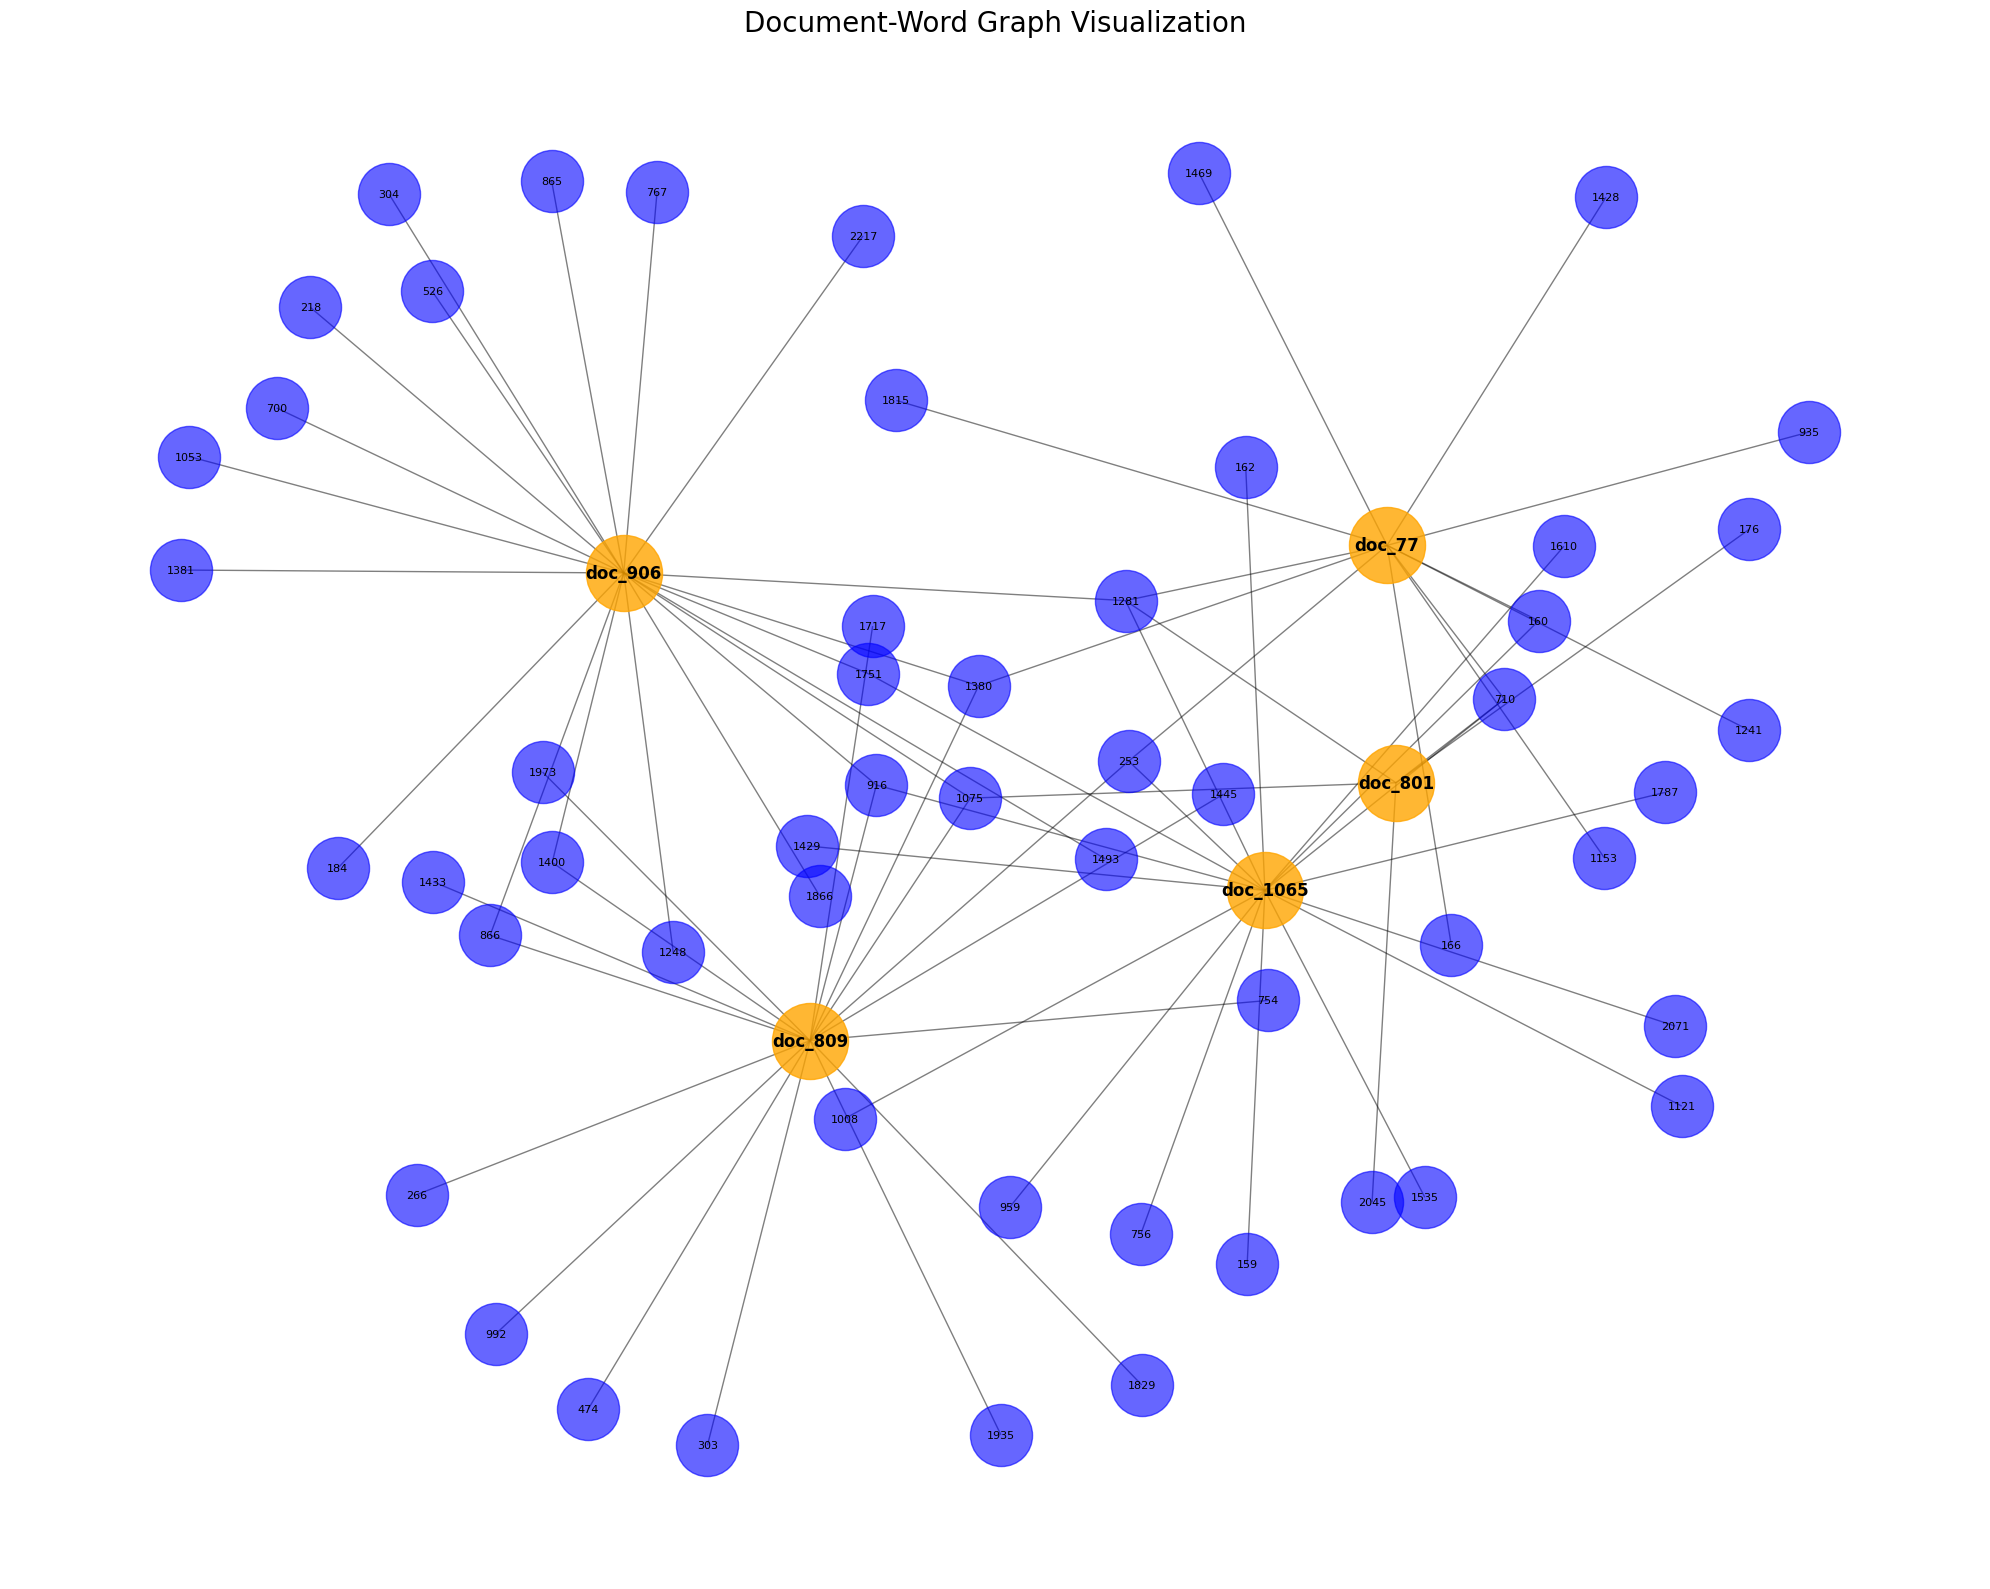

In [ ]:
# Visualize the graph
visualize_document_word_graph(train_data, num_docs=5, max_words_per_doc=20)

The primary graph is created at the **document-word level.**This means that the graph consists of two types of nodes:

Document nodes: **bold text** Representing individual documents in the dataset. (Entire row would be sitting here)

**Word nodes:** Representing unique words across all documents. (words of these documents would be here)

**The edges in this graph connect words to the documents they appear in**. This creates a bipartite graph structure where edges only exist between word nodes and document nodes, not between nodes of the same type.



## HeteroGNN

What is Heterogenous Graph?

Heterogeneous Graph Attention Network (HGAT) is an advanced graph neural network architecture designed to process and analyze heterogeneous graphs, which contain different types of nodes and edges. The key aspects of HGAT include:

Structure and Components

1. Hierarchical Attention Mechanism: HGAT employs a dual-level attention mechanism:
Node-level attention: Learns the importance between a node and its neighbors

2. Semantic-level attention: Learns the importance of different meta-paths or edge types.

3. Heterogeneity Handling: It can process graphs with multiple node and edge types, capturing rich semantic information12
Feature Aggregation: HGAT aggregates features from meta-path based neighbors in a hierarchical manner1

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, heads=4):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('word', 'to', 'doc'): GATConv((-1, -1), hidden_channels // heads, heads=heads, concat=True, add_self_loops=False),
                ('doc', 'to', 'word'): GATConv((-1, -1), hidden_channels // heads, heads=heads, concat=True, add_self_loops=False),
            })
            self.convs.append(conv)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        logits = self.lin(x_dict['doc'])
        return F.softmax(logits, dim=1)

# Training and evaluation functions
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = criterion(out, data['doc'].y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        pred = out.argmax(dim=1)
        probs = out.cpu().numpy()
        correct = (pred == data['doc'].y).sum()
        return correct.item() / len(data['doc'].y), pred, probs

def compute_metrics(train_true, train_pred, train_probs, test_true, test_pred, test_probs):
    def calculate_metrics(y_true, y_pred, y_probs):
        metrics = {
            "Precision": precision_score(y_true, y_pred, average="binary"),
            "Recall": recall_score(y_true, y_pred, average="binary"),
            "F1-Score": f1_score(y_true, y_pred, average="binary"),
            "Accuracy": accuracy_score(y_true, y_pred),
            "ROC-AUC": roc_auc_score(y_true, y_probs[:, 1]) if y_probs is not None else None
        }
        return metrics

    train_metrics = calculate_metrics(train_true, train_pred, train_probs)
    test_metrics = calculate_metrics(test_true, test_pred, test_probs)

    df = pd.DataFrame({
        'Train': train_metrics,
        'Test': test_metrics
    }).transpose()

    display(df)

    print("\nClassification Report (Train):")
    print(classification_report(train_true, train_pred))

    print("\nClassification Report (Test):")
    print(classification_report(test_true, test_pred))

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # ROC-AUC plot
    for true, probs, name in [(train_true, train_probs, 'Train'), (test_true, test_probs, 'Test')]:
        fpr, tpr, _ = roc_curve(true, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc="lower right")

    # Precision-Recall plot
    for true, probs, name in [(train_true, train_probs, 'Train'), (test_true, test_probs, 'Test')]:
        precision, recall, _ = precision_recall_curve(true, probs[:, 1])
        ax2.plot(recall, precision, label=f'{name}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()

    # Confusion Matrix for Train data
    train_cm = confusion_matrix(train_true, train_pred)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    ax3.set_title('Confusion Matrix (Train)')

    # Confusion Matrix for Test data
    test_cm = confusion_matrix(test_true, test_pred)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
    ax4.set_xlabel('Predicted')
    ax4.set_ylabel('Actual')
    ax4.set_title('Confusion Matrix (Test)')

    plt.tight_layout()
    plt.show()

    return df

> It uses HeteroConv layers with GATConv (Graph Attention) operations for both word-to-document and document-to-word message passing.

> The model aggregates information across the graph structure through multiple layers. The final layer produces document-level predictions.


## Fine-tuning to get the best model


Finetuning over 2 cv.

In [ ]:
best_params, best_score = grid_search(train_data)

Testing: hidden_channels=32, num_layers=2, heads=4, lr=0.0001
Fold 1/2
Epoch 0, Loss: 0.6840, Train Acc: 0.7701, Val Acc: 0.7741
Epoch 10, Loss: 0.6629, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 20, Loss: 0.6507, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 30, Loss: 0.6389, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 40, Loss: 0.6279, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 50, Loss: 0.6175, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 60, Loss: 0.6078, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 70, Loss: 0.5987, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 80, Loss: 0.5906, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 90, Loss: 0.5834, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 100, Loss: 0.5771, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 110, Loss: 0.5718, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 120, Loss: 0.5673, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 130, Loss: 0.5637, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 140, Loss: 0.5607, Train Acc: 0.7674, Val Acc: 0.7647
Epoch 150, Loss: 0.5583, Train Acc: 0.76

In [ ]:
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.4f}")


Best parameters: {'hidden_channels': 32, 'num_layers': 2, 'heads': 8, 'lr': 0.001}
Best cross-validation score: 0.8783


Epoch 0, Loss: 0.7278, Train Accuracy: 0.2266, Val Accuracy: 0.2433
Epoch 10, Loss: 0.6037, Train Accuracy: 0.7660, Val Accuracy: 0.7647
Epoch 20, Loss: 0.5544, Train Accuracy: 0.7660, Val Accuracy: 0.7647
Epoch 30, Loss: 0.5482, Train Accuracy: 0.7660, Val Accuracy: 0.7647
Epoch 40, Loss: 0.5474, Train Accuracy: 0.7660, Val Accuracy: 0.7647
Epoch 50, Loss: 0.5472, Train Accuracy: 0.7660, Val Accuracy: 0.7647
Epoch 60, Loss: 0.5468, Train Accuracy: 0.7660, Val Accuracy: 0.7647
Epoch 70, Loss: 0.5436, Train Accuracy: 0.7660, Val Accuracy: 0.7647
Epoch 80, Loss: 0.5242, Train Accuracy: 0.7774, Val Accuracy: 0.7834
Epoch 90, Loss: 0.4815, Train Accuracy: 0.8422, Val Accuracy: 0.8503
Epoch 100, Loss: 0.4457, Train Accuracy: 0.8697, Val Accuracy: 0.8556
Epoch 110, Loss: 0.4260, Train Accuracy: 0.8890, Val Accuracy: 0.8743
Epoch 120, Loss: 0.4118, Train Accuracy: 0.9064, Val Accuracy: 0.8930
Epoch 130, Loss: 0.3996, Train Accuracy: 0.9184, Val Accuracy: 0.8904
Epoch 140, Loss: 0.3890, Train 

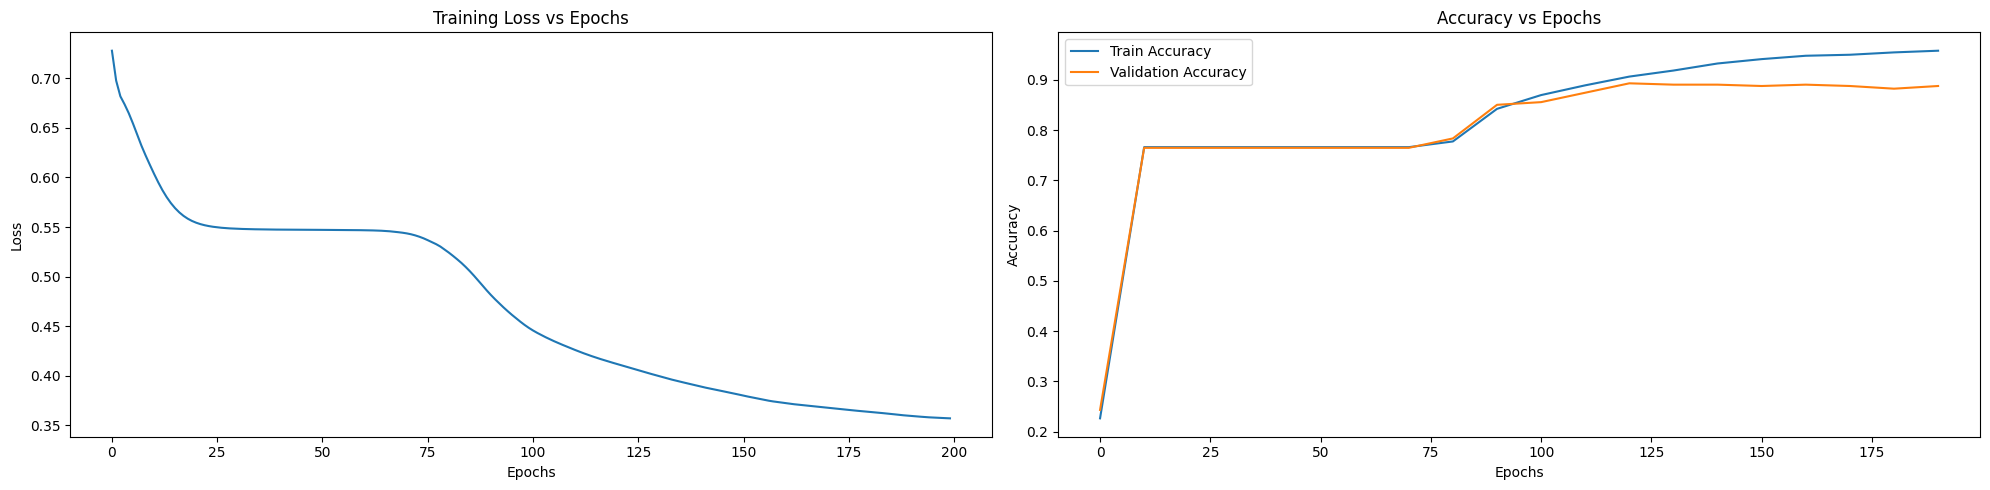

In [ ]:
GNN_optimal = HeteroGNN(
    hidden_channels=best_params['hidden_channels'],
    out_channels=len(set(y_train)),
    num_layers=best_params['num_layers'],
    heads=best_params['heads']
)

optimizer = torch.optim.Adam(GNN_optimal.parameters(), lr=best_params['lr'])
criterion = torch.nn.CrossEntropyLoss()


# Training loop
train_losses, train_accuracies, val_accuracies = [], [], []

epochs = 200

for epoch in range(epochs):
    loss = train(GNN_optimal, train_data, optimizer, criterion)
    train_losses.append(loss)

    if epoch % 10 == 0:
        train_acc, _, _ = evaluate(GNN_optimal, train_data)
        val_acc, _, _ = evaluate(GNN_optimal, test_data)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot training loss
ax1.plot(train_losses)
ax1.set_title('Training Loss vs Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# Plot accuracies
ax2.plot(range(0, epochs, 10), train_accuracies, label='Train Accuracy')
ax2.plot(range(0, epochs, 10), val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy vs Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

,Precision,Recall,F1-Score,Accuracy,ROC-AUC
Train,0.962457,0.984293,0.973253,0.958556,0.950095
Test,0.893891,0.972028,0.931323,0.890374,0.929315



Classification Report (Train):
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       350
           1       0.96      0.98      0.97      1146

    accuracy                           0.96      1496
   macro avg       0.95      0.93      0.94      1496
weighted avg       0.96      0.96      0.96      1496


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.87      0.62      0.73        88
           1       0.89      0.97      0.93       286

    accuracy                           0.89       374
   macro avg       0.88      0.80      0.83       374
weighted avg       0.89      0.89      0.88       374



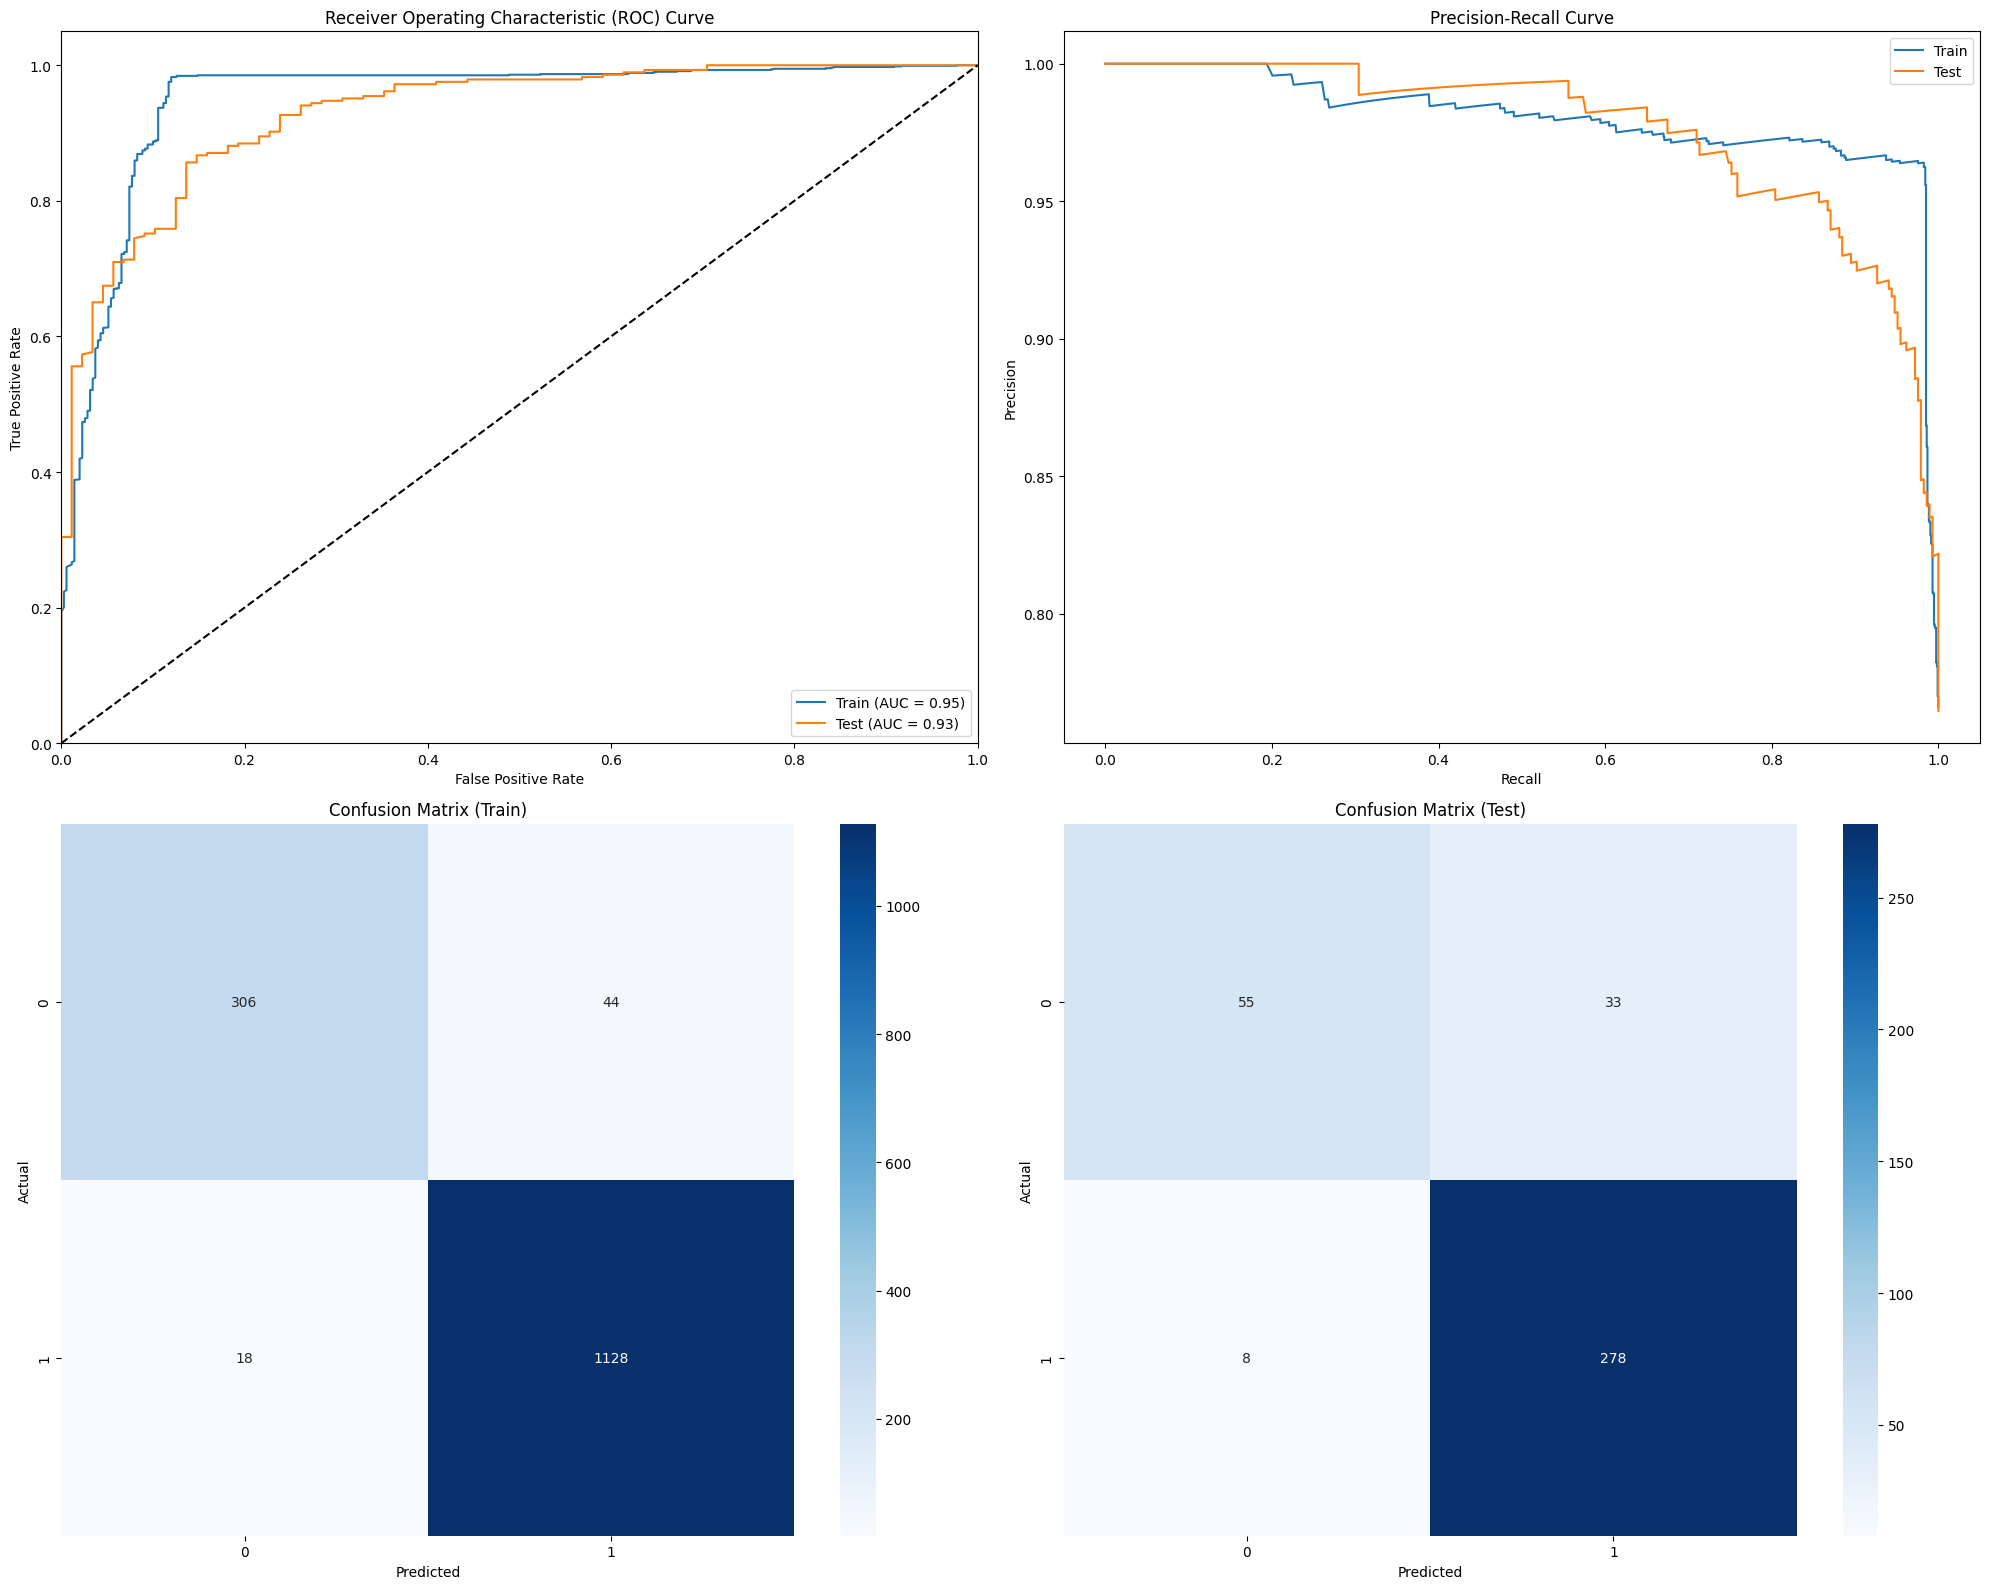

In [ ]:
# Final evaluation
train_acc, train_pred, train_probs = evaluate(GNN_optimal, train_data)
test_acc, test_pred, test_probs = evaluate(GNN_optimal, test_data)

# Compute and display metrics
metrics_df = compute_metrics(
    train_data['doc'].y.cpu().numpy(),
    train_pred.cpu().numpy(),
    train_probs,
    test_data['doc'].y.cpu().numpy(),
    test_pred.cpu().numpy(),
    test_probs
)

> We have not used any synthetic data here.

> The results look pretty good in terms of stability.



In [ ]:
# Define the path where you want to save the state dictionary
save_path = "GNN_optimal_state_dict.pth"

# Save the model's state dictionary
torch.save(GNN_optimal.state_dict(), save_path)

print(f"Model's state dictionary saved at {save_path}")

files.download(save_path)


Model's state dictionary saved at GNN_optimal_state_dict.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prediction Script


> Only for testing out. Not related to main sheet.

> Needed dummy data to complete the pipeline so just used the same data. This is not for evaluation purpose.

In [ ]:
import torch
import re
import spacy
from transformers import BertTokenizer, BertModel

# Load spaCy model and BERT tokenizer/model (assuming they're already initialized)
nlp = spacy.load('en_core_web_sm')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

dummy = pd.read_csv('train-1.csv').iloc[:1, :]
if "label" in dummy.columns:

  dummy.drop("label", axis=1, inplace=True)

cleaned_dummy = clean_and_process_data(dummy)
dummy_text, dummy_meta = cleaned_dummy["text"], cleaned_dummy["metaphor"]

dummy_words, dummy_edges = create_hetero_graph(dummy_text, dummy_meta)

dummy_word_features = create_bert_embeddings(dummy_words)
dummy_doc_features = create_bert_embeddings([text + " " + meta for text, meta in zip(dummy_text, dummy_meta)])

dummy_data = HeteroData()
dummy_data['word'].x = dummy_word_features
dummy_data['doc'].x = dummy_doc_features
dummy_data['word', 'to', 'doc'].edge_index = torch.tensor([[dummy_words.index(edge[1]) for edge in dummy_edges], [edge[3] for edge in dummy_edges]], dtype=torch.long)
dummy_data['doc'].y = torch.tensor(cleaned_dummy["target"])

# Add reverse edges
dummy_data['doc', 'to', 'word'].edge_index = dummy_data['word', 'to', 'doc'].edge_index.flip([0])

final_model = HeteroGNN(hidden_channels=32, out_channels=2, num_layers=2, heads=8)
final_model.load_state_dict(torch.load('GNN_optimal_state_dict.pth'))
final_model.eval()

# Use predicted object, ignore dummy_acc and dummy_probs
dummy_acc, predicted, dummy_probs = evaluate(final_model, dummy_data)



/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
<ipython-input-32-17c7ceba8491>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowli

> We have not used any synthetic data here.

> The results look pretty good in terms of stability.

